# Introduction
In this notebook, we will demonstrate how to create a stacked model using multiple base learners and a meta-learner. Stacking is an ensemble learning technique that combines the predictions of several base models to improve overall performance.

In [48]:
# import necessary libraries
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Load the dataset

In [49]:
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
y_val = pd.read_csv('../data/processed/y_val.csv')

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (160, 13)
y_train shape: (160, 1)
X_val shape: (40, 13)
y_val shape: (40, 1)


# Correlation check for OOF residuals

In [50]:
# load oof predictions
oof_xgb = pd.read_csv('../models/XGB/oof_preds_xgb.csv')
oof_lgbm = pd.read_csv('../models/LGBM/oof_preds_lgbm.csv')
oof_tabm = pd.read_csv('../models/TabM/oof_preds_tabm.csv')
oof_tabular = pd.read_csv('../models/Tabular/oof_preds_tabular.csv')

print(f"OOF XGB shape: {oof_xgb.shape}")
print(f"OOF LGBM shape: {oof_lgbm.shape}")
print(f"OOF TabM shape: {oof_tabm.shape}")
print(f"OOF Tabular shape: {oof_tabular.shape}")

# Merge by ID first to align properly
merged = (
    oof_xgb[["id", "xgb_preds"]]
    .merge(oof_lgbm[["id", "lgbm_preds"]], on="id")
    .merge(oof_tabm[["id", "tabm_preds"]], on="id")
    .merge(oof_tabular[["id", "tabular_preds"]], on="id")
)

# Then compare
diff_count = (merged["lgbm_preds"] != merged["xgb_preds"]).sum()
print(f"Different predictions (aligned by id): {diff_count} / {len(merged)}")

# or use np.isclose to ignore float noise
diff_count_tol = (~np.isclose(merged["lgbm_preds"], merged["xgb_preds"], atol=1e-9)).sum()
print(f"Different predictions beyond tolerance: {diff_count_tol}")

OOF XGB shape: (160, 3)
OOF LGBM shape: (414203, 3)
OOF TabM shape: (414203, 3)
OOF Tabular shape: (414203, 3)
Different predictions (aligned by id): 126 / 126
Different predictions beyond tolerance: 126


In [51]:
merged_noid = merged.drop('id', axis=1)
oof_corr = merged.corr()
print("OOF Predictions Correlation Matrix:")
print(oof_corr)

OOF Predictions Correlation Matrix:
                     id  xgb_preds  lgbm_preds  tabm_preds  tabular_preds
id             1.000000   0.137234    0.053573    0.048102       0.064291
xgb_preds      0.137234   1.000000    0.890499    0.884250       0.893415
lgbm_preds     0.053573   0.890499    1.000000    0.997693       0.994393
tabm_preds     0.048102   0.884250    0.997693    1.000000       0.994135
tabular_preds  0.064291   0.893415    0.994393    0.994135       1.000000


# Load models

In [52]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      40 non-null     int64  
 1   road_type               40 non-null     object 
 2   num_lanes               40 non-null     int64  
 3   curvature               40 non-null     float64
 4   speed_limit             40 non-null     int64  
 5   lighting                40 non-null     object 
 6   weather                 40 non-null     object 
 7   road_signs_present      40 non-null     int64  
 8   public_road             40 non-null     int64  
 9   time_of_day             40 non-null     object 
 10  holiday                 40 non-null     int64  
 11  school_season           40 non-null     int64  
 12  num_reported_accidents  40 non-null     int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 4.2+ KB


## LGBM

In [53]:
import joblib
from sklearn import set_config
reg_lgbm = joblib.load('../models/LGBM/reg_lgbm.pkl')

print(type(reg_lgbm))


set_config(display='diagram')
reg_lgbm

<class 'sklearn.pipeline.Pipeline'>


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [54]:
y_preds = reg_lgbm.predict(X_val)
reg_lgbm_preds = pd.DataFrame({
    "id": X_val["id"],
    "lgbm_preds": y_preds,
    "true_vals": np.ravel(y_val)
})

display(reg_lgbm_preds.head())
reg_lgbm_preds.to_csv('../models/LGBM/val_preds_lgbm.csv', index=False)

,id,lgbm_preds,true_vals
0,95,0.321774,0.37
1,15,0.362921,0.39
2,30,0.363450,0.38
3,158,0.652256,0.69
4,128,0.240140,0.29


## Tabular

In [55]:
from pytorch_tabular import TabularModel
import torch
import pandas as pd

# Load model
model_path = "../models/Tabular/tabular_model.pkl"
tabular = torch.load(model_path, map_location=torch.device('cpu'))

# Load new data (must have same columns)

# Make sure categorical columns are strings
for c in ["road_type", "lighting", "weather", "time_of_day"]:
    X_val[c] = X_val[c].astype(str)

# Predict
preds_df = tabular.predict(X_val)
print(preds_df.head())

y_preds_tabular = preds_df["accident_risk_prediction"].values
reg_tabular_preds = pd.DataFrame({
    "id": X_val["id"],
    "tabular_preds": y_preds_tabular,
    "true_vals": np.ravel(y_val)
})
display(reg_tabular_preds.head())
reg_tabular_preds.to_csv('../models/Tabular/val_preds_tabular.csv', index=False)

   accident_risk_prediction
0                  0.309491
1                  0.316370
2                  0.391100
3                  0.635925
4                  0.242134


,id,tabular_preds,true_vals
0,95,0.309491,0.37
1,15,0.316370,0.39
2,30,0.391100,0.38
3,158,0.635925,0.69
4,128,0.242134,0.29


## XGB

In [56]:
import joblib
from sklearn import set_config
reg_xgb = joblib.load('../models/XGB/reg_xgb.pkl')

print(type(reg_xgb))
set_config(display='diagram')
reg_xgb

<class 'sklearn.pipeline.Pipeline'>


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [57]:
y_preds = reg_xgb.predict(X_val)
reg_xgb_preds = pd.DataFrame({
    "id": X_val["id"],
    "xgb_preds": y_preds,
    "true_vals": np.ravel(y_val)
})
reg_xgb_preds.to_csv('../models/XGB/val_preds_xgb.csv', index=False)
reg_xgb_preds.head()

,id,xgb_preds,true_vals
0,95,0.301460,0.37
1,15,0.398222,0.39
2,30,0.342616,0.38
3,158,0.540636,0.69
4,128,0.260018,0.29


## TabM

In [58]:
from tabm import TabM

bundle = torch.load("../models/TabM/tabm_bundle.pkl", map_location="cpu")
model = TabM.make(**bundle["model_config"])
model.load_state_dict(bundle["model_state"])
model.eval()
scaler = bundle["scaler"]
encoders = bundle["encoders"]

In [59]:
 import torch

tabm = torch.load("../models/TabM/tabm_bundle.pkl", map_location="cpu")

model_cfg = tabm["model_config"]
model = TabM.make(**model_cfg)
model.load_state_dict(tabm["model_state"])
model.eval()

scaler = tabm["scaler"]
encoders = tabm["encoders"]

num_cols = ["num_lanes", "curvature", "speed_limit", "num_reported_accidents"]
cat_cols = ["road_type", "lighting", "weather", "time_of_day"]
bool_cols = ["road_signs_present", "public_road", "holiday", "school_season"]

print("✅ TabM model, scaler, and encoders successfully loaded.")

✅ TabM model, scaler, and encoders successfully loaded.


In [60]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import torch
import pandas as pd

class TabMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model, encoders, scaler,
                 num_cols, cat_cols, bool_cols,
                 device="cpu", batch_size=2048):
        self.model = model
        self.encoders = encoders
        self.scaler = scaler
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.bool_cols = bool_cols
        self.device = device
        self.batch_size = batch_size

    def fit(self, X, y=None):
        # TabM model is pre-trained; do nothing.
        return self

    def _preprocess_batch(self, X_batch):
        Xb = X_batch.copy()
        Xb[self.bool_cols] = Xb[self.bool_cols].astype(int)

        for col, le in self.encoders.items():
            Xb[col] = Xb[col].astype(str)
            Xb[col] = Xb[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

        Xb[self.num_cols + self.bool_cols] = self.scaler.transform(Xb[self.num_cols + self.bool_cols])
        x_num = torch.tensor(Xb[self.num_cols + self.bool_cols].to_numpy(copy=False), dtype=torch.float32).to(self.device)
        x_cat = torch.tensor(Xb[self.cat_cols].to_numpy(copy=False), dtype=torch.int64).to(self.device)
        return x_num, x_cat

    def predict(self, X):
        self.model.eval()
        preds_all = []
        for start in range(0, len(X), self.batch_size):
            end = min(start + self.batch_size, len(X))
            X_batch = X.iloc[start:end]
            x_num, x_cat = self._preprocess_batch(X_batch)
            with torch.no_grad():
                preds = self.model(x_num, x_cat).mean(1).squeeze(1).cpu().numpy()
            preds_all.append(preds)
            del X_batch, x_num, x_cat, preds
            if self.device == "cuda":
                torch.cuda.empty_cache()
        return np.concatenate(preds_all)

    # ───────────────────────────────────────────────
    # sklearn compatibility helpers
    # ───────────────────────────────────────────────
    def get_params(self, deep=True):
        # Return only simple attributes so sklearn can clone it
        return {
            "device": self.device,
            "batch_size": self.batch_size,
            "num_cols": self.num_cols,
            "cat_cols": self.cat_cols,
            "bool_cols": self.bool_cols
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def _more_tags(self):
        return {'requires_y': False}

In [61]:
# 1. Wrap TabM
tabm_reg = TabMWrapper(model, encoders, scaler,
                       num_cols, cat_cols, bool_cols)

In [62]:
y_preds = tabm_reg.predict(X_val)
print(y_preds)

reg_tabm_preds = pd.DataFrame({
    "id": X_val["id"],
    "tabm_preds": y_preds,
    "true_vals": np.ravel(y_val)
})
reg_tabm_preds.to_csv('../models/TabM/val_preds_tabm.csv', index=False)
reg_tabm_preds.head()

[0.31356874 0.3517757  0.37274987 0.6491722  0.2338177  0.3172741
 0.14645173 0.4049151  0.31385148 0.5514016  0.711323   0.4047327
 0.28283453 0.22931513 0.34111953 0.44142103 0.2974356  0.7358453
 0.3521227  0.25056934 0.11698217 0.20338202 0.26061764 0.17592855
 0.4538585  0.39472216 0.29808185 0.13823982 0.4676115  0.51311874
 0.11837713 0.71686256 0.61637765 0.3579029  0.20810463 0.5504064
 0.59929705 0.31382924 0.519519   0.5366404 ]


,id,tabm_preds,true_vals
0,95,0.313569,0.37
1,15,0.351776,0.39
2,30,0.372750,0.38
3,158,0.649172,0.69
4,128,0.233818,0.29


# Stage two - Meta model Stacked Regression

In [75]:
xgb_preds = pd.read_csv('../models/XGB/oof_preds_xgb.csv')
tabular_preds = pd.read_csv('../models/Tabular/oof_preds_tabular.csv')
# tabm_preds = pd.read_csv('../models/TabM/oof_preds_tabm.csv')
lgbm_preds = pd.read_csv('../models/LGBM/oof_preds_lgbm.csv')

In [76]:
base_learner_preds = [
    xgb_preds,
    # tabm_preds,
    tabular_preds,
    lgbm_preds
]

In [77]:
def stacked_dataset(pred_dfs, id_col='id', target_col='y_true'):
    """
    Merge multiple base learner DataFrames on ID and return stacked prediction matrix only.
    """
    # start from first DataFrame
    df_stack = pred_dfs[0][[id_col, target_col] +
                           [c for c in pred_dfs[0].columns if c.endswith("_preds")]].copy()

    # merge remaining ones by ID
    for df in pred_dfs[1:]:
        pred_cols = [c for c in df.columns if c.endswith("_preds")]
        df_stack = df_stack.merge(df[[id_col] + pred_cols], on=id_col, how="inner")

    # extract all *_preds columns into stacked matrix
    stackedX = df_stack[[c for c in df_stack.columns if c.endswith("_preds")]].to_numpy()
    y_train = df_stack[target_col].values

    return stackedX


In [78]:
stackedX = stacked_dataset(base_learner_preds)
print(stackedX.shape)
display(stackedX)

(414203, 3)


array([[0.31774324, 0.3186453 , 0.31761051],
       [0.26567394, 0.26708221, 0.26604687],
       [0.43827006, 0.43073317, 0.43967551],
       ...,
       [0.52632713, 0.5373615 , 0.52266197],
       [0.86003059, 0.86711872, 0.85903983],
       [0.44706017, 0.42853951, 0.44692435]])

In [81]:
from sklearn.linear_model import RidgeCV
def fit_stacked_model(base_learner_dfs, inputy):

    stackedX = stacked_dataset(base_learner_dfs)
    model = RidgeCV(alphas=[0.1, 1.0, 10.0])
    model.fit(stackedX, inputy)
    return model

stacked_model = fit_stacked_model(base_learner_preds, np.ravel(y_train))

## Evaluate

In [82]:
X_test = pd.read_csv('../data/processed/X_val.csv')
y_test = pd.read_csv('../data/processed/y_val.csv')

In [87]:
base_learners = [
    reg_xgb,
    reg_lgbm,
    # tabm_reg,
    tabular
]

In [88]:
for learner in base_learner_preds:
    print(learner.shape)

(414203, 3)
(414203, 3)
(414203, 3)


In [89]:
import numpy as np

def stacked_dataset(pred_dfs, id_col='id', target_col='y_true'):
    """
    Merge multiple base learner DataFrames on ID and return stacked prediction matrix only.
    """
    # start from first DataFrame
    df_stack = pred_dfs[0][[id_col, target_col] +
                           [c for c in pred_dfs[0].columns if c.endswith("_preds")]].copy()

    # merge remaining ones by ID
    for df in pred_dfs[1:]:
        pred_cols = [c for c in df.columns if c.endswith("_preds")]
        df_stack = df_stack.merge(df[[id_col] + pred_cols], on=id_col, how="inner")

    # extract all *_preds columns into stacked matrix
    stackedX = df_stack[[c for c in df_stack.columns if c.endswith("_preds")]].to_numpy()
    y_train = df_stack[target_col].values

    return stackedX


from sklearn.linear_model import RidgeCV

def fit_stacked_model(base_learner_dfs, inputy):

    stackedX = stacked_dataset(base_learner_dfs)
    model = RidgeCV(alphas=[0.1, 1.0, 10.0])
    model.fit(stackedX, inputy)
    return model

stacked_model = fit_stacked_model(base_learner_preds, np.ravel(y_train))

def stacked_prediction(members, inputX):
    preds = []

    for model in members:
        # handle models that don't support verbose arg
        try:
            yhat = model.predict(inputX, verbose=0)
        except TypeError:
            yhat = model.predict(inputX)

        yhat = np.array(yhat).reshape(-1, 1)
        preds.append(yhat)

    # horizontally stack predictions
    stackedX = np.hstack(preds)
    return stackedX

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate_stacked_model(base_learners, meta_model, X_test, y_true):
    # build stacked test matrix
    stackedX = stacked_prediction(base_learners, X_test)

    # meta-model prediction
    y_pred = meta_model.predict(stackedX)

    # metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)


    # if your test data has 'id' column
    if 'id' in X_test.columns:
        ids = X_test['id']
    else:
        print('There is no ID column in X_test.')
        ids = np.arange(len(X_test))  # fallback index if no ID

    # make DataFrame with predictions
    df_results = pd.DataFrame({
        "id": ids,
        "y_true": np.ravel(y_true),
        "y_pred": np.ravel(y_pred)
    })

    print(df_results.head())

    df_results.to_csv('../models/Stacked/stacked_yhat.csv', index=False)

    print(f"Stacked Model → RMSE: {rmse:.5f} | R²: {r2:.5f}")
    return rmse, r2

rmse, r2 = evaluate_stacked_model(base_learners, stacked_model, X_test, y_test)

       id  y_true    y_pred
0   50309    0.15  0.222827
1   95219    0.20  0.351133
2  197653    0.29  0.343095
3  111236    0.25  0.290039
4  147247    0.32  0.342114
Stacked Model → RMSE: 0.09700 | R²: 0.65923


# Stacking helped?

In [90]:
import pandas as pd

xgb_df = pd.read_csv('../models/XGB/val_preds_xgb.csv')
lgbm_df = pd.read_csv('../models/LGBM/val_preds_lgbm.csv')[['id', 'lgbm_preds']]
tabm_df = pd.read_csv('../models/TabM/val_preds_tabm.csv')[['id', 'tabm_preds']]
tabular_df = pd.read_csv('../models/Tabular/val_preds_tabular.csv')[['id', 'tabular_preds']]
stacked_df = pd.read_csv('../models/Stacked/stacked_yhat.csv')[['id', 'y_pred']].rename(columns={'y_pred': 'stacked_preds'})

# merge all
compare = xgb_df.merge(lgbm_df, on='id').merge(stacked_df, on='id').merge(tabm_df, on='id').merge(tabular_df, on='id')
compare.head()

,id,xgb_preds,true_vals,lgbm_preds,stacked_preds,tabm_preds,tabular_preds
0,30,0.342616,0.38,0.363450,0.344080,0.372750,0.391100
1,170,0.400484,0.34,0.410103,0.399821,0.404915,0.386493
2,186,0.373010,0.40,0.354160,0.372356,0.341120,0.351729
3,177,0.445887,0.44,0.426763,0.445181,0.441421,0.422882
4,75,0.343592,0.32,0.373194,0.344111,0.357903,0.368041


In [91]:
for name, coef in zip(['xgb', 'lgbm', 'tabm', 'tabular'], stacked_model.coef_):
    print(f"{name:10} → {coef:.4f}")

xgb        → 0.9738
lgbm       → -0.0096
tabm       → 0.0358


# Try Non-Linear meta model (XGB)

In [ ]:
    model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42,
    )

In [103]:
import numpy as np
from xgboost import XGBRegressor
import joblib


def stacked_dataset(pred_dfs, id_col='id', target_col='y_true'):
    """
    Merge multiple base learner DataFrames on ID and return stacked prediction matrix only.
    """
    # start from first DataFrame
    df_stack = pred_dfs[0][[id_col, target_col] +
                           [c for c in pred_dfs[0].columns if c.endswith("_preds")]].copy()

    # merge remaining ones by ID
    for df in pred_dfs[1:]:
        pred_cols = [c for c in df.columns if c.endswith("_preds")]
        df_stack = df_stack.merge(df[[id_col] + pred_cols], on=id_col, how="inner")

    # extract all *_preds columns into stacked matrix
    stackedX = df_stack[[c for c in df_stack.columns if c.endswith("_preds")]].to_numpy()
    y_train = df_stack[target_col].values

    return stackedX


from sklearn.linear_model import RidgeCV

def fit_stacked_model(base_learner_dfs, inputy):

    stackedX = stacked_dataset(base_learner_dfs)
    model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42,
    )
    model.fit(stackedX, inputy)
    return model

stacked_model = fit_stacked_model(base_learner_preds, np.ravel(y_train))

def stacked_prediction(members, inputX):
    preds = []

    for model in members:
        # handle models that don't support verbose arg
        try:
            yhat = model.predict(inputX, verbose=0)
        except TypeError:
            yhat = model.predict(inputX)

        yhat = np.array(yhat).reshape(-1, 1)
        preds.append(yhat)

    # horizontally stack predictions
    stackedX = np.hstack(preds)
    return stackedX

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate_stacked_model(base_learners, meta_model, X_test, y_true):
    # build stacked test matrix
    stackedX = stacked_prediction(base_learners, X_test)

    # meta-model prediction
    y_pred = meta_model.predict(stackedX)

    # metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)


    # if your test data has 'id' column
    if 'id' in X_test.columns:
        ids = X_test['id']
    else:
        print('There is no ID column in X_test.')
        ids = np.arange(len(X_test))  # fallback index if no ID

    # make DataFrame with predictions
    df_results = pd.DataFrame({
        "id": ids,
        "y_true": np.ravel(y_true),
        "y_pred": np.ravel(y_pred)
    })

    print(df_results.head())

    df_results.to_csv('../models/Stacked/stacked_yhat.csv', index=False)
    joblib.dump(stacked_model, "../models/Stacked/stacked_model.pkl")

    print(f"Stacked Model → RMSE: {rmse:.5f} | R²: {r2:.5f}")
    return rmse, r2

rmse, r2 = evaluate_stacked_model(base_learners, stacked_model, X_test, y_test)

       id  y_true    y_pred
0   50309    0.15  0.192963
1   95219    0.20  0.346401
2  197653    0.29  0.337287
3  111236    0.25  0.290098
4  147247    0.32  0.333397
Stacked Model → RMSE: 0.08980 | R²: 0.70796


In [101]:
import pandas as pd

xgb_df = pd.read_csv('../models/XGB/val_preds_xgb.csv')
lgbm_df = pd.read_csv('../models/LGBM/val_preds_lgbm.csv')[['id', 'lgbm_preds']]
# tabm_df = pd.read_csv('../models/TabM/val_preds_tabm.csv')[['id', 'tabm_preds']]
tabular_df = pd.read_csv('../models/Tabular/val_preds_tabular.csv')[['id', 'tabular_preds']]
stacked_df = pd.read_csv('../models/Stacked/stacked_yhat_xgb.csv')[['id', 'y_pred']].rename(columns={'y_pred': 'stacked_preds'})

# merge all
compare = xgb_df.merge(lgbm_df, on='id').merge(stacked_df, on='id').merge(tabular_df, on='id')
compare.head()

,id,xgb_preds,true_vals,lgbm_preds,stacked_preds,tabular_preds
0,30,0.342616,0.38,0.363450,0.366458,0.391100
1,170,0.400484,0.34,0.410103,0.403773,0.386493
2,186,0.373010,0.40,0.354160,0.355948,0.351729
3,177,0.445887,0.44,0.426763,0.424213,0.422882
4,75,0.343592,0.32,0.373194,0.374778,0.368041


xgb       : 0.8027
lgbm      : 0.0024
tabm      : 0.1949


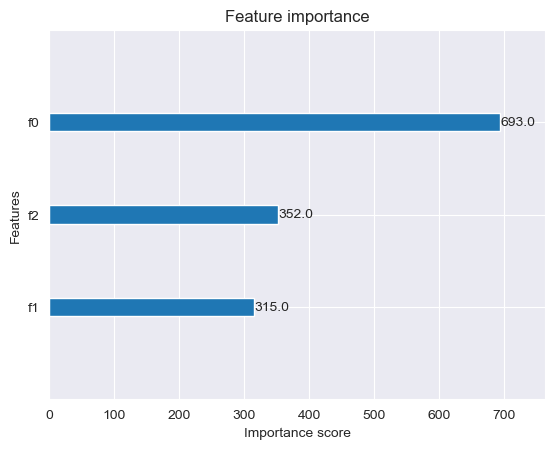

In [99]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# meta_model is your trained XGBRegressor on stackedX
importances = stacked_model.feature_importances_
for name, score in zip(['xgb', 'lgbm', 'tabm', 'tabular'], importances):
    print(f"{name:10}: {score:.4f}")

plot_importance(stacked_model)
plt.show()